# CNN project using partial Quick Draw dataset


Data source : https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap

This project uses Keras to implement a CNN model and comprises of the following parts :

(1) A CNN model which classifies images downloaded from the Quick Draw dataset.
    Quickdraw images used are in the 28 x 28 numpy bitmap format. 
    Program reads all quick draw .npy files from './data_quickdraw_npy/' sub-directory.
    Model has been trained on a downloaded quick draw sub-dataset of 40 classes with 2000 images per class.
    Program can accept varying number of classes (determined by the number of downloaded .npy files) and 
    images per class can be changed by resetting global variable n_images_per_class.
    The trained keras model has been saved in the sub-directory './model/'.

(2) The model is used to predict class of objects in selected images of drawings from outside the quickdraw data set.

(3) A database of feature vectors has been compiled for the downloaded quick draw sub-dataset and 
    saved in the sub-directory './data/'. 

(4) A simple nearest image search routine based on shortest euclidean distance between 
    the feature vector of a test image and the feature vectors from the compiled quick draw feature vector database
    is used to display quick draw images closest to the test image.




# Imports and Inits

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

import tensorflow as tf

import os
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.8
1.3.0


In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "thisNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
# global variables
IMGROW = 28
IMGCOL = 28
IMGSIZ = 784        # IMGROW * IMGCOL

n_data_per_class = 5000  # this can be changed up to about 100,000 depending 
                         # on the minimum of available images per class across all classes

class_dtype = 'int8'     # assumming number of classes <= 2^7 or 128, can be changed to accommodate bigger number of classes

dir_quickdraw_npy = './data_quickdraw_npy/'
dir_image = './data_image/'
dir_data = './data/'
dir_model = './model/'

prf = './data_quickdraw_npy/full%2Fnumpy_bitmap%2F'  # quickdraw files prefix
plen = len('full%2Fnumpy_bitmap%2F')


fname_model = dir_model + thisNotebook
fname_feature_vec_npy = dir_data + thisNotebook + '.npy'

print(fname_model)
print(fname_feature_vec_npy)

./model/CNN_QuickDraw_3c1d5000
./data/CNN_QuickDraw_3c1d5000.npy


# Read dataset from downloaded from quickdraw

In [5]:
ff = os.listdir(dir_quickdraw_npy)
classes = []
for i,f in enumerate(ff):
    cf = f[plen:]   # remove front part of file name to get class tag
    c = cf[:len(cf)-4]   # remove .npy file extension from class tag 
    classes.append(c)
if i >= np.iinfo(np.int8).max:
    print("Please change class_dtype in global variables section above to a larger integer representation")
print("Number of classes :", i+1)
print(classes)
n_classes = len(classes)


Number of classes : 40
['airplane', 'apple', 'banana', 'baseball bat', 'basket', 'bee', 'bicycle', 'bird', 'bus', 'cactus', 'calculator', 'camel', 'candle', 'cat', 'donut', 'duck', 'eye', 'face', 'flip flops', 'flower', 'grapes', 'hedgehog', 'house plant', 'ladder', 'light bulb', 'microphone', 'moon', 'octopus', 'palm tree', 'pencil', 'pizza', 'rabbit', 'school bus', 'scissors', 'sheep', 'snake', 't-shirt', 'The Eiffel Tower', 'umbrella', 'windmill']


In [6]:
n_data_all = n_data_per_class * n_classes

img_count = []
x_data = np.zeros((n_data_all,IMGSIZ))

for i, c in enumerate(classes):

    fname = prf + c + '.npy'
    tmp_data = np.load(fname)

    # check shape of data
    img_count.append(tmp_data.shape[0])
    #print("Class",c,"data shape :",tmp_data.shape)
    if tmp_data.shape[1] != IMGSIZ or tmp_data.shape[0] < n_data_per_class:
        print('Error in', c)
        break

    # take random sample from read images
    random_samples = np.arange(tmp_data.shape[0])
    np.random.shuffle(random_samples)

    # copy first n_data_per_class random samples
    x_data[i*n_data_per_class:(i+1)*n_data_per_class,:] = tmp_data[random_samples[0:n_data_per_class],:]


#print(img_count)
#print(sorted(img_count))
print(x_data.shape)

(200000, 784)


In [7]:
#labels = [np.full((n_data_per_class,), classes.index(s)) for s in classes]
#y_data = np.concatenate(labels,axis=0)  ## Concat the arrays together

y_data = np.zeros(n_data_all,dtype=class_dtype)
for i, c in enumerate(classes):
    y_data[i*n_data_per_class:(i+1)*n_data_per_class] = i
    #print(y_data[i*n_data_per_class],y_data[(i+1)*n_data_per_class-1])

In [8]:
print(x_data.shape, y_data.shape) 
print(x_data.dtype, y_data.dtype)

(200000, 784) (200000,)
float64 int8


# Shuffle and split data

In [9]:
frac_trn = 0.8
frac_val = 0.1
frac_tes = 0.1
samples_to_print =  5

assert((frac_trn + frac_val + frac_tes)==1.0)

iend_trn = int(frac_trn * n_data_all)
iend_val = int(frac_val * n_data_all) + iend_trn
print("iend_train, iend_val :",iend_trn, iend_val)

random_indices = np.random.permutation(n_data_all)

nrand_trn = random.randint(0, int(frac_trn * n_data_all)-samples_to_print)
nrand_val = random.randint(0, int(frac_val * n_data_all)-samples_to_print)
nrand_tes = random.randint(0, int(frac_tes * n_data_all)-samples_to_print)

rs_trn = random_indices[           nrand_trn :            nrand_trn + samples_to_print]
rs_val = random_indices[iend_trn + nrand_val : iend_trn + nrand_val + samples_to_print]
rs_tes = random_indices[iend_val + nrand_tes : iend_val + nrand_tes + samples_to_print]
print("Sampling trn :", rs_trn)
print("Sampling val :", rs_val)
print("Sampling tes :", rs_tes)
sc_trn = rs_trn / n_data_per_class
sc_val = rs_val / n_data_per_class
sc_tes = rs_tes / n_data_per_class
sc_trn = sc_trn.astype('int32')
sc_val = sc_val.astype('int32')
sc_tes = sc_tes.astype('int32')
print("Expected classes trn :", sc_trn)
print("Expected classes tes :", sc_val)
print("Expected classes val :", sc_tes)

print("-------------------------")


x_data_shuffled = x_data[random_indices,:]
y_data_shuffled = y_data[random_indices]
print("x_data_shuffled, y_data_shuffled shapes :", x_data_shuffled.shape,y_data_shuffled.shape)

print(y_data_shuffled[           nrand_trn :            nrand_trn + samples_to_print])
print(y_data_shuffled[iend_trn + nrand_val : iend_trn + nrand_val + samples_to_print])
print(y_data_shuffled[iend_val + nrand_tes : iend_val + nrand_tes + samples_to_print])
print("-------------------------")

x_trn = x_data_shuffled[:iend_trn,:]
y_trn = y_data_shuffled[:iend_trn]

x_val = x_data_shuffled[iend_trn:iend_val,:]
y_val = y_data_shuffled[iend_trn:iend_val]

x_tes = x_data_shuffled[iend_val:,:]
y_tes = y_data_shuffled[iend_val:]

print("x_trn, x_val, x_tes shapes:", x_trn.shape, x_val.shape, x_tes.shape)
print("y_trn, y_val, y_tes shapes:", y_trn.shape, y_val.shape, y_tes.shape)
print(y_trn[nrand_trn : nrand_trn + samples_to_print])
print(y_val[nrand_val : nrand_val + samples_to_print])
print(y_tes[nrand_tes : nrand_tes + samples_to_print])


iend_train, iend_val : 160000 180000
Sampling trn : [ 94549   9303 172974   9756  61156]
Sampling val : [189277 158989  80897 148814 152652]
Sampling tes : [ 34799 174940  27644 118111 116525]
Expected classes trn : [18  1 34  1 12]
Expected classes tes : [37 31 16 29 30]
Expected classes val : [ 6 34  5 23 23]
-------------------------
x_data_shuffled, y_data_shuffled shapes : (200000, 784) (200000,)
[18  1 34  1 12]
[37 31 16 29 30]
[ 6 34  5 23 23]
-------------------------
x_trn, x_val, x_tes shapes: (160000, 784) (20000, 784) (20000, 784)
y_trn, y_val, y_tes shapes: (160000,) (20000,) (20000,)
[18  1 34  1 12]
[37 31 16 29 30]
[ 6 34  5 23 23]


## Check Images - plot histogram of classes

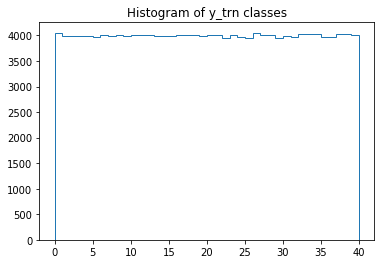

In [10]:
plt.hist(y_trn, bins=n_classes, range=[0, n_classes], histtype='step')

plt.title("Histogram of y_trn classes")
plt.show()


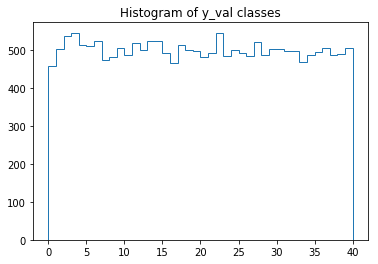

In [11]:
plt.hist(y_val, bins=n_classes, range=[0, n_classes], histtype='step')

plt.title("Histogram of y_val classes")
plt.show()

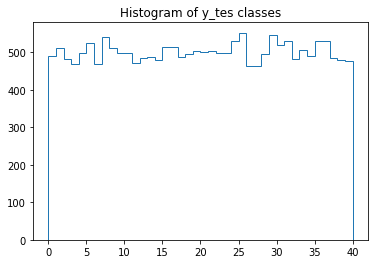

In [12]:
plt.hist(y_tes, bins=n_classes, range=[0, n_classes], histtype='step')

plt.title("Histogram of y_tes classes")
plt.show()

## Check Images - plot random samples

In [13]:
def show_object(obj):
    # Reshape IMGSIZ array into IMGROW x IMGCOL image
    image = obj.reshape([IMGROW,IMGCOL])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

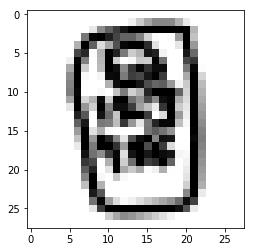

Random sample trn : 42461 10 calculator


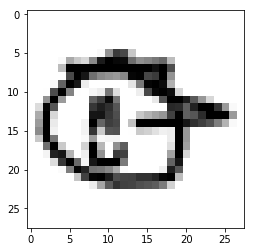

Random sample val : 5151 17 face


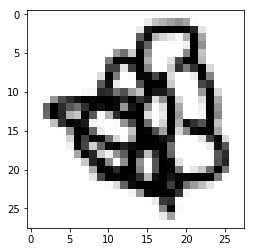

Random sample tes: 13369 19 flower


In [14]:
# show random object and label
n = int(random.uniform(0,1)*len(y_trn))
show_object(x_trn[n])
print("Random sample trn :", n, y_trn[n],classes[y_trn[n]])

n = int(random.uniform(0,1)*len(y_val))
show_object(x_val[n])
print("Random sample val :",n, y_val[n],classes[y_val[n]])

n = int(random.uniform(0,1)*len(y_tes))
show_object(x_tes[n])
print("Random sample tes:",n, y_tes[n],classes[y_tes[n]])

# Reshape and normalise x data

In [15]:
# reshape the data into format (width, Height, channels)
input_shape = (IMGROW, IMGCOL, 1)

x_trn = x_trn.reshape(x_trn.shape[0], IMGROW, IMGCOL, 1)
x_val = x_val.reshape(x_val.shape[0], IMGROW, IMGCOL, 1)
x_tes = x_tes.reshape(x_tes.shape[0], IMGROW, IMGCOL, 1)

x_trn = x_trn.astype('float32')
x_val = x_val.astype('float32')
x_tes = x_tes.astype('float32')

x_trn /= 255
x_val /= 255
x_tes /= 255

print(x_trn.shape, x_val.shape, x_tes.shape)


(160000, 28, 28, 1) (20000, 28, 28, 1) (20000, 28, 28, 1)


# Generate one-hot for y data

In [16]:
# convert class vectors to binary class matrices

y_trn_1hot = keras.utils.to_categorical(y_trn, n_classes)
y_val_1hot = keras.utils.to_categorical(y_val, n_classes)
y_tes_1hot = keras.utils.to_categorical(y_tes, n_classes)

print(y_trn.shape, y_val.shape, y_tes.shape)
print(y_trn_1hot.shape, y_val_1hot.shape, y_tes_1hot.shape)


(160000,) (20000,) (20000,)
(160000, 40) (20000, 40) (20000, 40)


# Define Model

In [17]:
# Model

batch_size = 32
epochs = 25

Inp = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu',name = 'Conv_01')(Inp)
x = Conv2D(16, (3, 3), activation='relu',name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)

x = Conv2D(16, (3, 3), activation='relu',name = 'Conv_03')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_02')(x)
x = Dropout(0.25,name = 'Dropout_01')(x)

x = Flatten(name = 'Flatten_01')(x)
x = Dense(512, activation='relu',name = 'Dense_01')(x)
x = Dropout(0.25,name = 'Dropout_02')(x)
output = Dense(n_classes, activation='softmax',name = 'Dense_02')(x)



In [18]:
model = Model(Inp,output)

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 26, 26, 16)        160       
_________________________________________________________________
Conv_02 (Conv2D)             (None, 24, 24, 16)        2320      
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 12, 12, 16)        0         
_________________________________________________________________
Conv_03 (Conv2D)             (None, 10, 10, 16)        2320      
_________________________________________________________________
MaxPool_02 (MaxPooling2D)    (None, 5, 5, 16)          0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 5, 5, 16)          0         
__________

# Compile and Run Model with Train and Validation data

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [21]:
hist = model.fit(x_trn, y_trn_1hot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = None,
          validation_data=(x_val, y_val_1hot))

Train on 160000 samples, validate on 20000 samples
Epoch 1/25
160000/160000 [==============================] - 173s - loss: 1.3460 - acc: 0.6277 - val_loss: 0.8909 - val_acc: 0.7520
Epoch 2/25
160000/160000 [==============================] - 180s - loss: 0.9721 - acc: 0.7260 - val_loss: 0.7737 - val_acc: 0.7841
Epoch 3/25
160000/160000 [==============================] - 180s - loss: 0.8688 - acc: 0.7540 - val_loss: 0.7032 - val_acc: 0.8022
Epoch 4/25
160000/160000 [==============================] - 185s - loss: 0.8095 - acc: 0.7690 - val_loss: 0.6792 - val_acc: 0.8104
Epoch 5/25
160000/160000 [==============================] - 191s - loss: 0.7694 - acc: 0.7800 - val_loss: 0.6420 - val_acc: 0.8204
Epoch 6/25
160000/160000 [==============================] - 188s - loss: 0.7454 - acc: 0.7868 - val_loss: 0.6309 - val_acc: 0.8218
Epoch 7/25
160000/160000 [==============================] - 183s - loss: 0.7173 - acc: 0.7942 - val_loss: 0.6121 - val_acc: 0.8272
Epoch 8/25
160000/160000 [======

In [22]:
model.save(fname_model)

In [23]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    

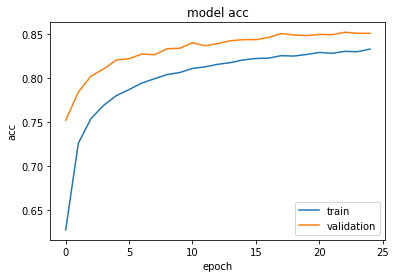

In [24]:
plot_train(hist)

# Evaluate model with Test data

In [25]:
model = load_model(fname_model)

In [25]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate(x_tes, y_tes_1hot,
          batch_size=batch_size)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

20000/20000 [==============================] - 5s     
Model Accuracy = 0.85
Model Loss = 0.53


# Test model with images outside QuickDraw dataset

In [26]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

In [27]:
# read an image file and return numpy array of dimension (1,IMGROW,IMGCOL,1)
def read_img_file(fname):
    img = image.load_img(fname, grayscale=False, target_size=(IMGROW, IMGROW))
    x = image.img_to_array(img)
    x = np.expand_dims(x[:,:,0], axis=2)
    x = np.expand_dims(x, axis=0)
    x /= 255
    x = 1 - x   # invert image
    return x

Original image :


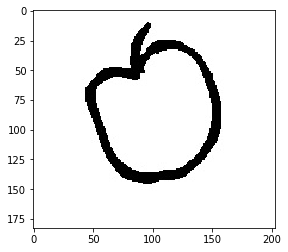

Processed image :


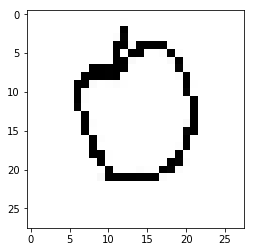

Image shape, x shape: (183, 203, 3) (1, 28, 28, 1)


In [28]:
# show original
fname = dir_image + 'apple10.jpg'

img=mpimg.imread(fname)
print('Original image :')
plt.imshow(img)
plt.show()

# show processed image fed into CNN model
x = read_img_file(fname)
print('Processed image :')
show_object(x*255)

print("Image shape, x shape:",img.shape,x.shape)

In [29]:
prediction = model.predict(x)
y = np.argmax(prediction)
#print(type(prediction),prediction.shape)
print("Predicted class :", classes[y])

Predicted class : hedgehog


# Create file of QuickDraw image features

In [30]:
# define feature_model
vec = model.get_layer('Dense_01')
feature_model = Model(inputs=model.input, outputs=vec.output)

In [31]:
x_data_images = x_data.reshape(x_data.shape[0], IMGROW, IMGCOL, 1)
x_data_images /= 255
x = np.expand_dims(x_data_images[0],axis=0)
print("x_data, x_data_images, x shapes :", x_data.shape, x_data_images.shape,x.shape)

x_data, x_data_images, x shapes : (200000, 784) (200000, 28, 28, 1) (1, 28, 28, 1)


In [32]:
# create image embedding with large quickdraw dataset with model trained on small quickdraw dataset above
# find nearest quickdraw image to images outside of quickdraw dataset 

x_all_vec = []
for i in range(n_data_all):
    x = np.expand_dims(x_data_images[i],axis=0)
    fvec = feature_model.predict(x)
    x_all_vec.append(fvec[0])

print(len(x_all_vec))

200000


In [33]:
np.save(fname_feature_vec_npy, np.asarray(x_all_vec))

# Nearest image search against QuickDraw image feature file

In [35]:
x_all_vec_np = np.load(fname_feature_vec_npy)
x_all_vec = np.ndarray.tolist(x_all_vec_np)

In [34]:
from scipy.spatial import distance

fname = dir_image + 'apple10.jpg'

test_img = read_img_file(fname)
test_img_vec = feature_model.predict(test_img)

# make a list of euclidian distances between quickdraw images and the image I am checking

dist = []
for i, v in enumerate(x_all_vec):
    dist.append(np.linalg.norm(v - test_img_vec))

lowest_idx = sorted(range(len(dist)), key=dist.__getitem__)

Processed input image:


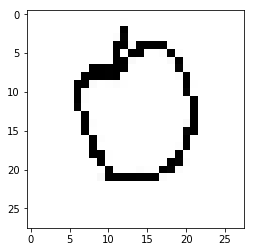

Nearest image 0 Class : cactus


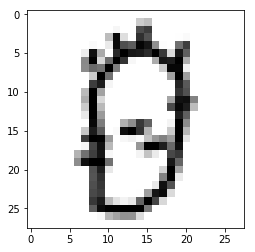

Nearest image 1 Class : hedgehog


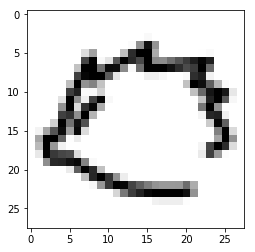

Nearest image 2 Class : hedgehog


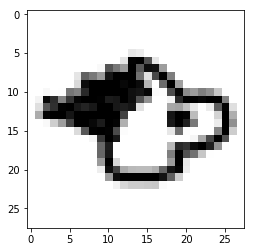

Nearest image 3 Class : bird


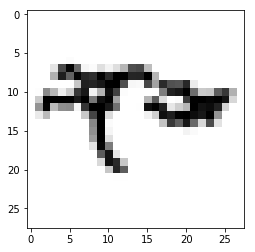

Nearest image 4 Class : microphone


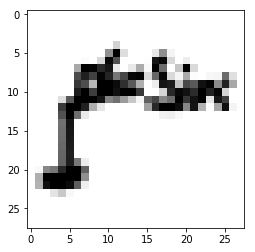

In [35]:
print("Processed input image:")
show_object(test_img*255)

nearest_class = []
for i in range(5):
    xx = x_data_images[lowest_idx[i]] * 255
    nearest_class.append(classes[y_data[lowest_idx[i]]])
    print("Nearest image",i,"Class :",nearest_class[i])
    show_object(xx)